<h1 style="text-align:center">Twitter Downloader</h1>

<span style="font-family:monospace">
Autor: Cicero Tiago<br>
Criado em: 13 de junho de 2020<br>
Última atualização: 15 de junho de 2020<br>
Sem nenhum motivo relevante;
</span>

<h2>Importando as bibliotecas necessárias</h2>

É importante lembrar que **todo** o código aqui escrito foi pensando para rodar em `jupyter`. Se você quiser criar um script, é preciso que faça algumas modificações.

In [1]:
try:
    import tweepy
except:
    !pip install tweepy
finally:
    import tweepy
try:
    from wordcloud import WordCloud
except:
    !pip install wordcloud
finally:
    from wordcloud import WordCloud

import pandas as pd
import numpy as np
import time
import json
import re
from os import listdir
from stopwords import stopWords
import requests
from os import mkdir

<h2>Carregando as credenciais</h2>
<p>Legalmente, o twitter exige que você tenha autorização para baixar dados de lá.<br>Para conseguir autorização, <a href="https://developer.twitter.com/en/docs/basics/getting-started"><strong>clique aqui</strong></a> e procure pela seção <strong>How to get started with the Twitter APIs</strong>.</p>

Suas credenciais devem ser algo parecido com isso:


``` python
{
 'consumer_key': 'A7JZWbYwBybWeiAYB84S6gvwy',
 'consumer_secret': 'iSAIgxVObcBTIzI2pLdeEtnNxU5tXqEOK1PRqM2fblNb3DHsYe',
 'access_token': '7vJP5O5Lyd9764-y1uuSe78e844pQ50AMn16g2816Y67I8j01P',
 'access_token_secret': 'Hv0VIZ5Bq53lPR1jsESD4mVUQpPm94zmngvrN4mW04pwId'
}
```

(<i>keys meramente ilustrativas</i>)
<p>No meu caso, salvei em um arquivo chamado <b style="color:red">auth.json</b></p>

In [2]:
# open credentials
with open("auth.json", "r") as auth:
    credentials = json.load(auth)

In [3]:
consumerKey = credentials["consumer_key"]
consumerSecret = credentials["consumer_secret"]
accessToken = credentials["access_token"]
accessTokenSecret = credentials["access_token_secret"]

In [4]:
# criar o "objeto" de autenticação
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

# setar access token e access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

# Criar o objeto API
api = tweepy.API(authenticate, wait_on_rate_limit=True)

<h2>Função que carrega <i>tweets</i> já baixados de um arquivo</h2>
<p style="max-width:70vw">Essa função serve para fazer <i>checkpoints</i>.</p>

In [5]:
def load_tweets(id) -> list:
    id = id.replace("@","")
    if ".database" in listdir():
        if id in listdir(".database"):
            with open(".database/"+id, 'r') as file:
                tweets = [json.loads(line) for line in file.readlines()]
            print(f"{len(tweets)} Tweets carregados de .database/{id}")
        else:
            print(f"Nenhum tweet em .database/{id}")
            tweets = []
    else:
        !md ".database"
        tweets = [] 
    return tweets

<h2>Função que salva <i>tweets</i> baixados em um arquivo</h2>
<p style="max-width:70vw">Essa função serve para fazer <i>checkpoints</i>.</p>

In [6]:
def save_tweets(id, tweets_list):
    with open(f".database/{id}", 'w+') as file:
        file.write("\n".join([json.dumps(list_item) for list_item in tweets_list]))

<h2>Função que identifica arquivos de mídia no tweet</h2>
<p style="max-width:70vw">Recebe um json com metadados e extra urls que apontam para imagens, gifs ou videos.</p>

In [7]:
def get_media_from_json(status_json):

    if "media" in status_json["entities"]:

        def get_video_url(media):
            # função interna que só precisa ser utilizada aqui dentro.
            # Não há necessidade de uma definição formal só pra ela
            for variant in media["video_info"]["variants"]:
                if variant['content_type'] == 'video/mp4':
                    return variant["url"]

        medias_list = []

        for media in status_json["extended_entities"]["media"]:
            if media["type"] == "photo":
                medias_list.append(media["media_url_https"])
            elif media["type"] == "video" or media["type"] == "animated_gif":
                medias_list.append(media["media_url_https"])
                medias_list.append(get_video_url(media))
        return medias_list

<h2>Função que baixa arquivos de mídia</h2>
<p>Recebe uma lista de urls, o id do tweet e o id do usuário</p>
<p>Ex:
    <span style="color:red">0120310237401283</span>_1.mp4
</p>

In [8]:
def media_downloader(medias_list: list, tweet_id: int, user_id: str):
    if f".{user_id}" not in listdir(".database"):
        path = ".database/." + user_id
        mkdir(path)
    for index, url in enumerate(medias_list):
        try:
            ext = re.search("\.[mjp][pn][4g]", url)[0]
            filename = f"{tweet_id}_{index}{ext}"
            data = requests.get(url).content
            with open(f".database/.{user_id}/{filename}", 'wb+') as handler:
                handler.write(data)
        except:
            pass

<h2>Função que carrega e baixa <i>tweets</i></h2>
<p>Essa função baixa <i>tweets</i> e retorna uma lista de dicionários.</p>

**`id:str`**: id do usuário com ou sem "@"<br>
**`count:int`**: quantidade de tweets a serem baixados; `default=9999`<br>
**`download:bool`**: baixa novos tweets se for `True`; `default=False`<br>

In [24]:
def get_tweets_list(id: str, count: int = 9999, download_tweets: bool = False, 
                    download_images: bool = False, sleep: bool = True) -> list:
    id = id.replace("@", "")
    global global_status

    # essa função serve para lidar com os finais das iterações
    def limit_handled(cursor):
        running = True
        while running:
            try:
                yield cursor.next()
            except tweepy.RateLimitError:
                print("\nAtingiu o Limite de downloads."+
                    f"Aguarde até: {time.ctime(time.time()+15*60)} para continuar.")
                running = not running
            except StopIteration:
                print("\nTerminou todas as iterações")
                return None

    # tenta carregar tweets já baixados
    tweets = load_tweets(id=id)

    # se o parâmetro download for falso, retorna a lista de tweets que foi carregada de .database
    if not download_tweets:
        if not tweets:
            print("Nenhum tweet foi baixado. Use download=True para baixar")
        return tweets
    # cria uma lista de timestamps (certamente únicos)
    timestamps = [tweet["ID"] for tweet in tweets]

    # controle
    tweets_repetidos = 0
    tweets_baixados = 0
    loop_counter = 0
    start_time = time.time()

    # loop principal
    for status in limit_handled(tweepy.Cursor(api.user_timeline, 
                                              id=id, tweet_mode="extended").items(count)):
        # se a timestamp do tweet baixado não existir na lista
        if (status.id) not in timestamps:
            tweets_baixados += 1
            print('Tweets baixados: {0} | Tempo gasto: {1}s\r'.format(
                tweets_baixados, int(time.time()-start_time)), end="")
            loop_counter += 1
            tweet = {}
            tweet["extended"] = status._json # salva metadados para análise posterior
            tweet["ID"] = status.id # id da postagem
            tweet['User_Name'] = status.user.name # username do usuário (talvez pareça redundante)
            tweet['Created_At'] = int(status.created_at.timestamp()) # data de criação
            tweet['Text'] = status.full_text # texto integral
            tweet['Phone_Type'] = status.source # tipo de dispositivo que postou
            tweet['Favorite_Count'] = status.favorite_count # numero de likes
            tweet['Retweets'] = status.retweet_count # numero de retweets
            tweet["Language"] = status.lang # idioma do texto, se houver
            # se o tweet mencionar terceiros
            if status.entities["user_mentions"]:
                tweet['Mentions'] = [mention["screen_name"]
                                     for mention in status.entities["user_mentions"]]
            # se o tweet possuir hashtags
            if status.entities["hashtags"]:
                tweet['Hashtags'] = [hashtag['text']
                                     for hashtag in status.entities["hashtags"]]
            # se o tweet possuir urls
            if status.entities["urls"]:
                tweet["Url"] = [url["expanded_url"]
                                for url in status.entities["urls"]]
            
            # tenta baixar videos, gif e imagens, se houver
            tweet["Media"] = get_media_from_json(status._json)
            
            # se download_images for True, salva as midias identificadas
            if download_images and tweet["Media"] != None:
                media_downloader(medias_list=tweet["Media"],
                                 tweet_id=tweet["ID"], user_id=id)
            
            # guarda o tweet baixado na lista
            tweets.append(tweet)
            
            # a cada 10 itens guardados, o programa salva (evita perdas por crashes
            # imprevistos e/ou queda de conexão)
            if loop_counter % 10 == 0:
                save_tweets(id=id, tweets_list=tweets)
                
            # se o parâmetro sleep for Trur, aguarda 3 segundos antes de realizar outra iteração
            if sleep:
                time.sleep(3)
        
        # se a timestamp já estiver na lista de timestamps, vai para a próxima iteração
        else:
            tweets_repetidos += 1
            loop_counter += 1
    
    print(f"Tweets repetidos: {max([0,tweets_repetidos])}")
    print(f"Tweets baixados: {tweets_baixados}")
    
    # salva a lista de tweets após terminar todas as iterações
    save_tweets(id=id, tweets_list=tweets)
    
    # retorna lista de tweets
    return tweets

<h2>Função de limpeza</h2>
<p style="max-width:70vw">Recebe uma string e devolve a mesma string removendo expressões como <strong>mentions</strong>, <strong>links</strongstrong>, <i>retweets</strong> e <strong>hashtags</strong>.</p>

In [10]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9\_]+', '', text)  # remove @mentions
    text = re.sub('#', '', text)  # remove #hashtag
    text = re.sub('RT[\s]+', '', text)  # remove RT
    text = re.sub('https?:\/\/\S+', '', text)  # remove links
    return text

<h2>Frunção que gera o dataframe</h2>
<p style="max-width:70vw">Essa função cria o <i>dataframe</i> e limpa a coluna <strong>Text</strong>.</p>

In [11]:
def create_dataframe(tweet_list) -> pd.DataFrame:
    # função interna que aplica a função de limpeza em um dataframe que possui coluna "Text"
    # não tem problema aplicar ela diretamente no dataframe porque mentions, links e hashtags
    # são guardadas em suas respectivas colunas
    def cleanDataframe(dataframe) -> pd.DataFrame:
        new_df = dataframe.copy()
        # aplica a função de limpeza na coluna "Text"
        new_df['Text'] = new_df['Text'].apply(cleanTxt)
        return new_df

    dataframe = pd.DataFrame(tweet_list)
    return cleanDataframe(dataframe)

<h2>Frunção que gera uma <i>Word Cloud</i></h2>
<p style="max-width:70vw">Essa função gera uma <strong>Word Cloud</strong> partindo de um dataframe limpo.</p>

In [12]:
def generateWordCloud(tweet_dataframe, save: bool = False, width: int = 1500, height: int = 500):
    tweets = tweet_dataframe["Text"]
    allWords = ' '.join([twts for twts in tweets])
    wc = WordCloud(width=width,
                   height=height,
                   random_state=42,
                   max_font_size=110,
                   stopwords=stopWords)
    gen = wc.generate(allWords)
    return gen.to_image()

<h2>Teste</h2>
<p style="max-width:70vw">Hora de <strong>testar</strong>.</p>

In [13]:
twitter_list = get_tweets_list(id="@cicerotcv", count=300, download_images=True, download_tweets=True, sleep=False)

50 Tweets carregados de .database/cicerotcv
Tweets baixados: 230 | Tempo gasto: 60s
Terminou todas as iterações
Tweets repetidos: 50
Tweets baixados: 230


In [14]:
my_tweets = create_dataframe(twitter_list)
print(f"shape: {my_tweets.shape}")

shape: (280, 13)


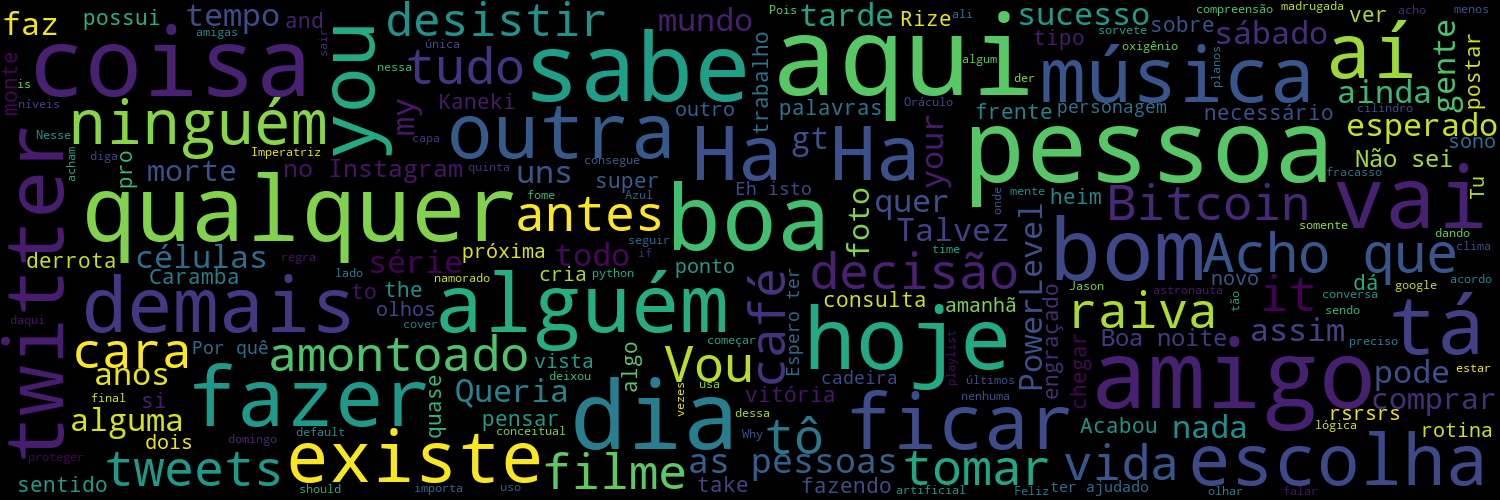

In [16]:
generateWordCloud(my_tweets, width=1500, height=500)

<h2>Extras</h2>
<p style="max-width:70vw; font-family:monospace">Sua análise começa aqui &#128540;</p>

link interessante sobre WordClouds:<br>
https://amueller.github.io/word_cloud/auto_examples/masked.html